In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm

In [3]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'

In [4]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [5]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

# Import stations

In [5]:
stations_point = gpd.read_file('./clean_data/stations_point.geojson')
stations_area = gpd.read_file('./clean_data/stations_area.geojson')

In [6]:
# radius in km
radius = (stations_area.to_crs(epsg_2d)['geometry'].iloc[0].area / np.pi)**0.5 / 10**3

Text(0.5, 1.0, 'TTC subway stations with radius of 0.40km')

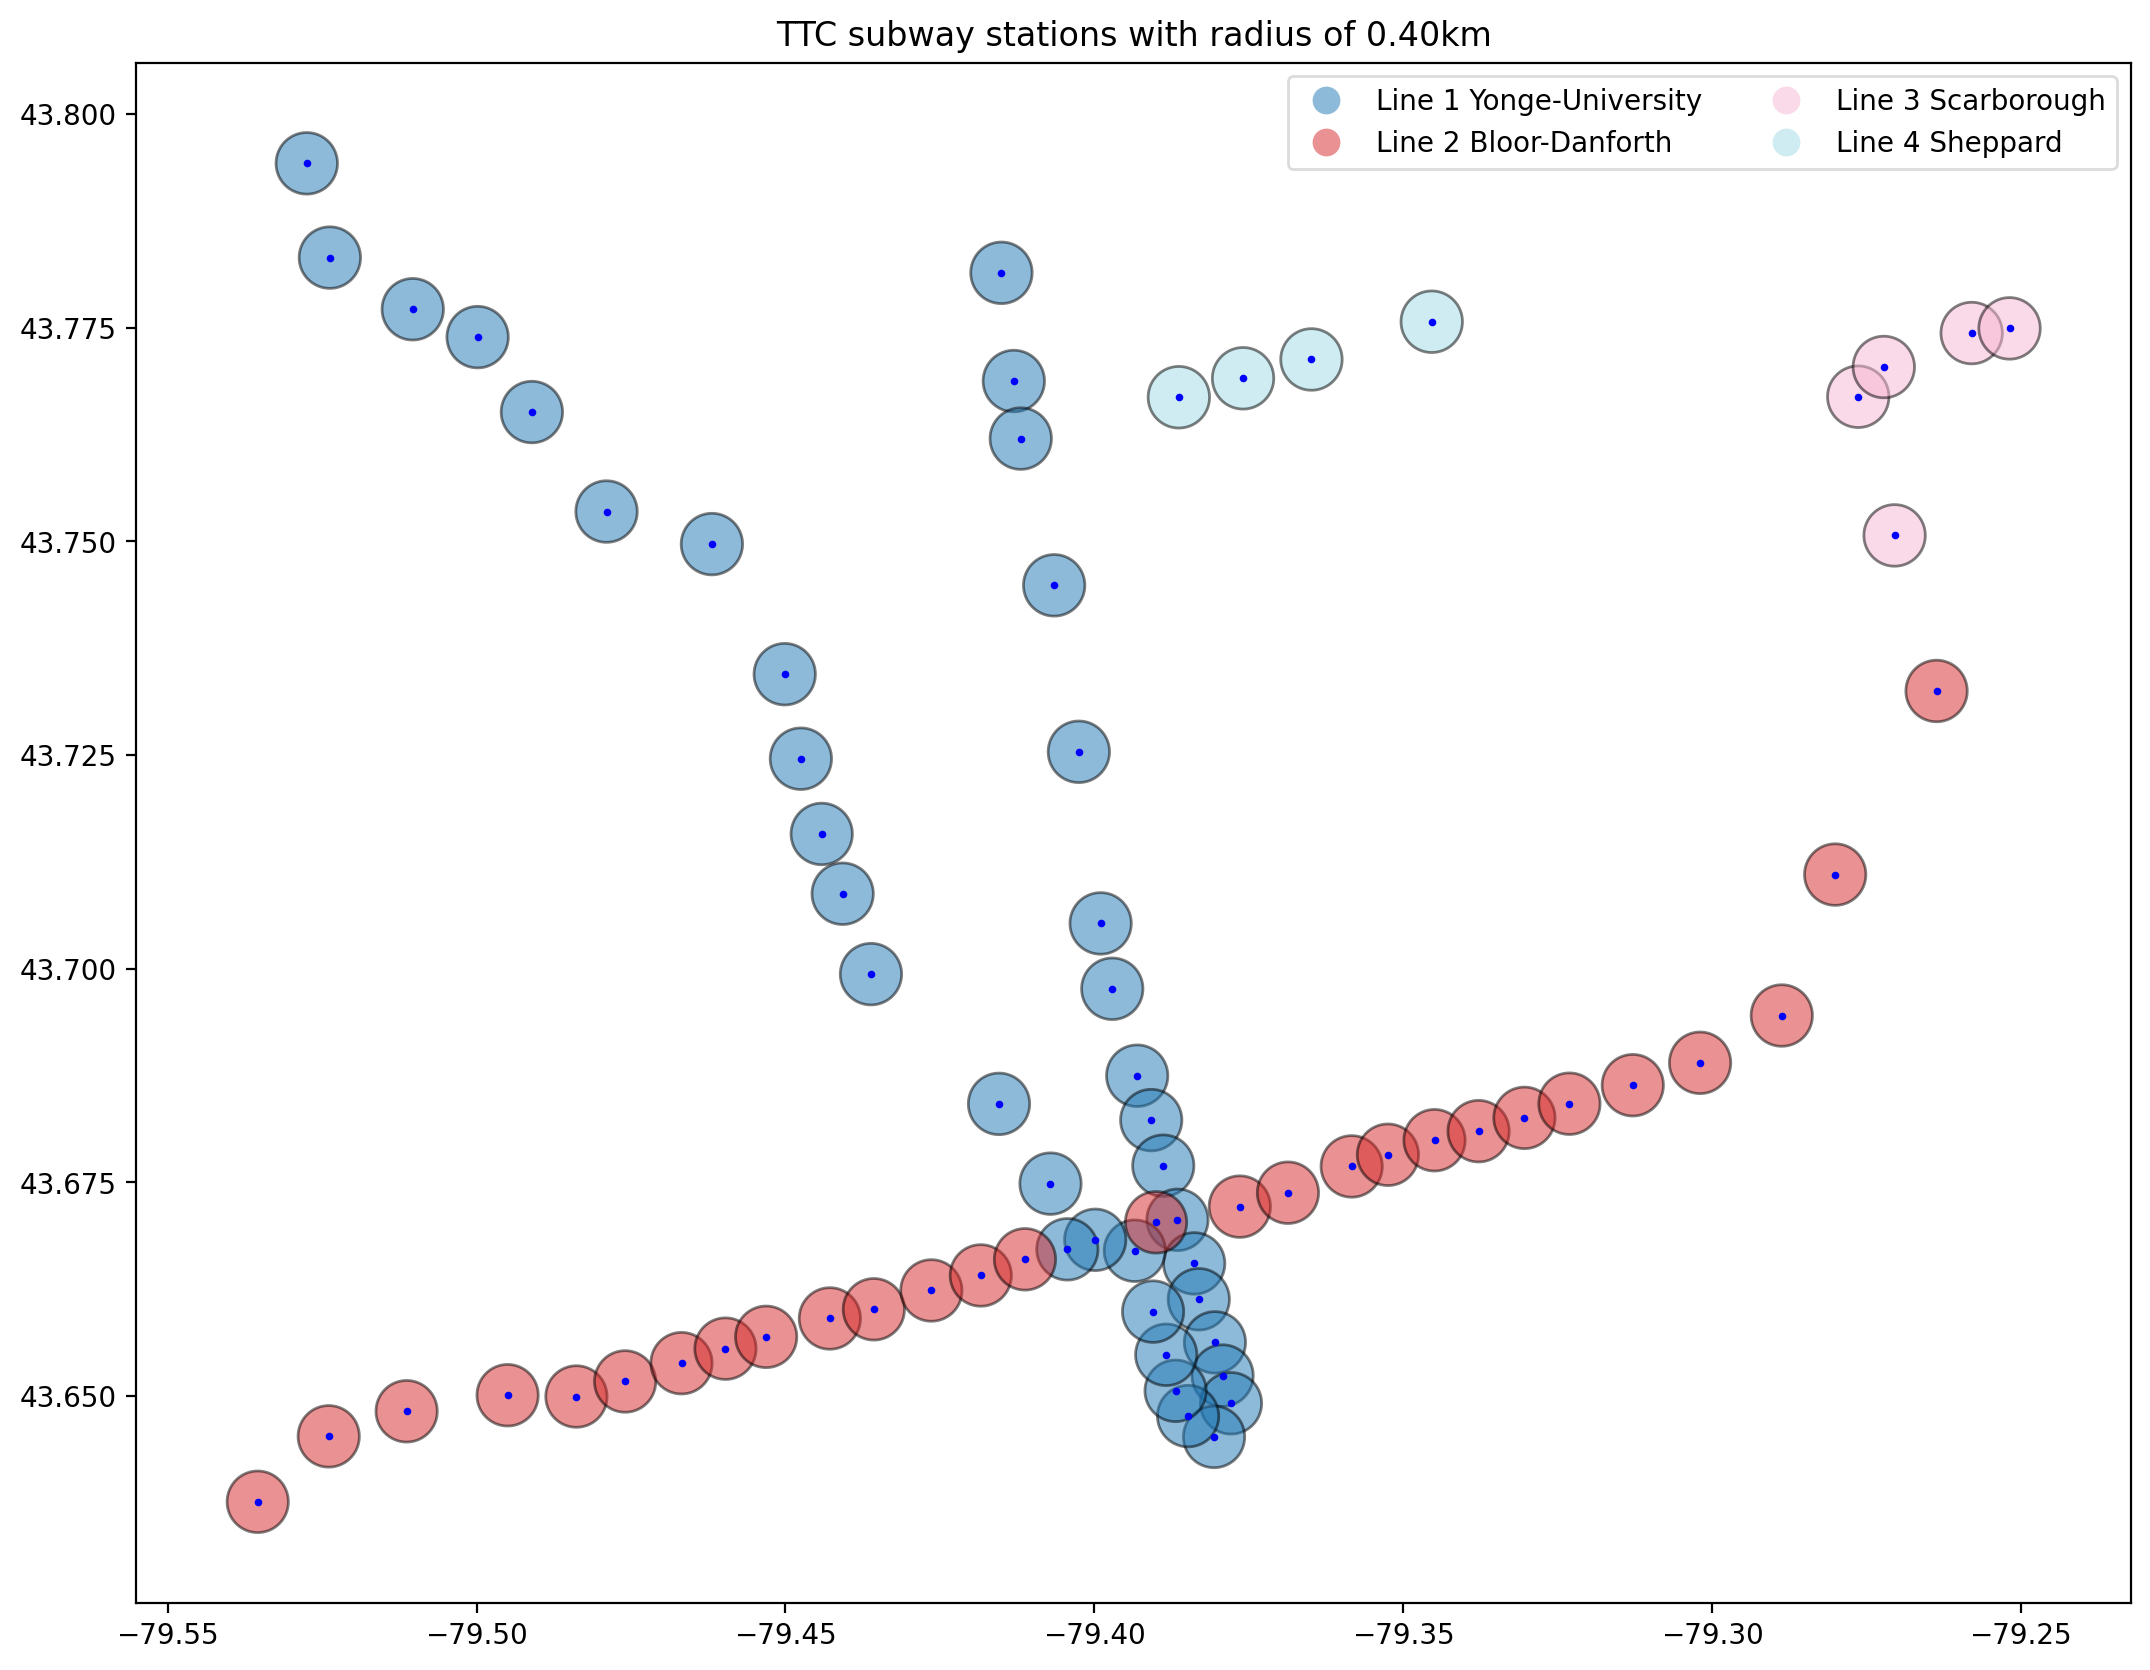

In [7]:
ax = stations_area.plot(column = 'line', 
                        edgecolor = 'black', 
                        alpha = 0.5,
                        cmap = 'tab20',
                        legend = True,
                        legend_kwds = {'loc': 'upper right', 
                                       'ncol': 2,
                                       'edgecolor': 'lightgrey'})
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)
plt.title(f'TTC subway stations with radius of {radius:0.2f}km')

# Import neighbourhoods

In [6]:
neighborhoods = gpd.read_file('./raw_data/Neighbourhood_Crime_Rates_2020.geojson')
neighborhoods.head()

ImportError: the 'read_file' function requires the 'fiona' package, but it is not installed or does not import correctly.
Importing fiona resulted in: DLL load failed while importing ogrext: The specified module could not be found.

In [9]:
neighborhoods.iloc[:,0:4].columns.values

array(['OBJECTID', 'Neighbourhood', 'Hood_ID',
       'F2020_Population_Projection'], dtype=object)

In [10]:
neighborhoods.iloc[:,4:-3].columns.values

array(['Assault_2014', 'Assault_2015', 'Assault_2016', 'Assault_2017',
       'Assault_2018', 'Assault_2019', 'Assault_2020', 'Assault_Rate2014',
       'Assault_Rate2015', 'Assault_Rate2016', 'Assault_Rate2017',
       'Assault_Rate2018', 'Assault_Rate2019', 'Assault_Rate2020',
       'AutoTheft_2014', 'AutoTheft_2015', 'AutoTheft_2016',
       'AutoTheft_2017', 'AutoTheft_2018', 'AutoTheft_2019',
       'AutoTheft_2020', 'AutoTheft_Rate2014', 'AutoTheft_Rate2015',
       'AutoTheft_Rate2016', 'AutoTheft_Rate2017', 'AutoTheft_Rate2018',
       'AutoTheft_Rate2019', 'AutoTheft_Rate2020', 'BreakAndEnter_2014',
       'BreakAndEnter_2015', 'BreakAndEnter_2016', 'BreakAndEnter_2017',
       'BreakAndEnter_2018', 'BreakAndEnter_2019', 'BreakAndEnter_2020',
       'BreakAndEnter_Rate2014', 'BreakAndEnter_Rate2015',
       'BreakAndEnter_Rate2016', 'BreakAndEnter_Rate2017',
       'BreakAndEnter_Rate2018', 'BreakAndEnter_Rate2019',
       'BreakAndEnter_Rate2020', 'Robbery_2014', 'Robbery_20

In [11]:
crime_counts = sorted(list(set([re.search('[a-zA-Z]+', x).group(0) for x in neighborhoods.iloc[:,4:-3].columns.values])))
crime_counts

['Assault',
 'AutoTheft',
 'BreakAndEnter',
 'Homicide',
 'Robbery',
 'RobberyRate',
 'Shooting',
 'Shootings',
 'TheftOver']

In [12]:
# RobberyRate_2015 and Shooting_Rate2014 are in a different format vs other crime rates
[x for x in neighborhoods.columns.values if ('RobberyRate' in x) | ('Shooting_Rate' in x)]

['RobberyRate_2015', 'Shooting_Rate2014']

In [13]:
neighborhoods.rename(columns={'RobberyRate_2015': 'Robbery_Rate2015',
                              'Shooting_Rate2014': 'Shootings_Rate2014'},
                     inplace=True)

In [14]:
# now crime counts are correct
crime_counts = sorted(list(set([re.search('[a-zA-Z]+', x).group(0) for x in neighborhoods.iloc[:,4:-3].columns.values])))
crime_counts

['Assault',
 'AutoTheft',
 'BreakAndEnter',
 'Homicide',
 'Robbery',
 'Shootings',
 'TheftOver']

In [15]:
# now crime rates are correct
crime_rates = sorted(list(set([re.search('[a-zA-Z]+_Rate', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Rate', x) is not None])))
crime_rates

['Assault_Rate',
 'AutoTheft_Rate',
 'BreakAndEnter_Rate',
 'Homicide_Rate',
 'Robbery_Rate',
 'Shootings_Rate',
 'TheftOver_Rate']

In [16]:
years = sorted(list(set([re.search('[0-9]+', x).group(0) for x in neighborhoods.iloc[:,4:-3].columns.values])))
years

['2014', '2015', '2016', '2017', '2018', '2019', '2020']

In [17]:
# crime density = crime count / area in 1 km^2
for x in crime_counts:
    for year in years:
        neighborhoods[x + '_Density' + str(year)] = neighborhoods[x + '_' + str(year)] / (neighborhoods['geometry'].to_crs(epsg_2d).area / 10**6)

In [18]:
crime_density = sorted(list(set([re.search('[a-zA-Z]+_Density', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Density', x) is not None])))
crime_density

['Assault_Density',
 'AutoTheft_Density',
 'BreakAndEnter_Density',
 'Homicide_Density',
 'Robbery_Density',
 'Shootings_Density',
 'TheftOver_Density']

In [19]:
for year in years:
    neighborhoods['All_' + str(year)] = neighborhoods[[x + "_" + str(year)for x in crime_counts]].sum(axis=1)
    neighborhoods['Population_' + str(year)] = (neighborhoods[[x + "_" + str(year)for x in crime_counts]] / neighborhoods[[x + "_Rate" + str(year)for x in crime_counts]].values).fillna(axis=1, method='bfill').replace([np.inf, -np.inf], np.nan).fillna(axis=1, method='ffill').mean(axis=1)*10**5
    print(f"{year} Population in City of Toronto is {neighborhoods['Population_' + str(year)].sum():0,.0f}")
    neighborhoods['All_Rate' + str(year)] = neighborhoods['All_' + str(year)] / neighborhoods['Population_' + str(year)] * 10**5
    neighborhoods['All_Density' + str(year)] = neighborhoods['All_' + str(year)] / (neighborhoods['geometry'].to_crs(epsg_2d).area / 10**6)

2014 Population in City of Toronto is 2,776,942
2015 Population in City of Toronto is 2,795,256
2016 Population in City of Toronto is 2,822,888
2017 Population in City of Toronto is 2,875,230
2018 Population in City of Toronto is 2,917,481
2019 Population in City of Toronto is 2,987,098
2020 Population in City of Toronto is 3,042,042


In [20]:
crime_rates = sorted(list(set([re.search('[a-zA-Z]+_Rate', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Rate', x) is not None])))
crime_rates

['All_Rate',
 'Assault_Rate',
 'AutoTheft_Rate',
 'BreakAndEnter_Rate',
 'Homicide_Rate',
 'Robbery_Rate',
 'Shootings_Rate',
 'TheftOver_Rate']

In [21]:
crime_density = sorted(list(set([re.search('[a-zA-Z]+_Density', x).group(0) for x in neighborhoods.columns.values if re.search('[a-zA-Z]+_Density', x) is not None])))
crime_density

['All_Density',
 'Assault_Density',
 'AutoTheft_Density',
 'BreakAndEnter_Density',
 'Homicide_Density',
 'Robbery_Density',
 'Shootings_Density',
 'TheftOver_Density']

In [22]:
def plot_crime(var, title):
    fig, axes = plt.subplots(len(years), len(var))

    for j in range(axes.shape[1]):
        # fix the range for the colorbar so we can compare across years for each crime rate
        vmin, vmax = neighborhoods[[var[j] + str(year) for year in years]].min().min(), neighborhoods[[var[j] + str(year) for year in years]].max().max()
        norm = TwoSlopeNorm(vmin=vmin, vcenter= np.mean([vmin, vmax]), vmax=vmax)
        for i in range(axes.shape[0]):    
            neighborhoods.plot(column = var[j] + str(years[i]), 
                            cmap = 'viridis',
                            norm = norm,
                            #    legend = True,
                            ax = axes[i, j])
            # x.set_title(col)
            axes[i,j].xaxis.set_visible(False)
            axes[i,j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(var[j].split("_")[0])
            if j == 0:
                axes[i,j].set_ylabel(years[i], rotation=90, size='large')

    # fig.tight_layout()

    fig.suptitle(title, size='xx-large')

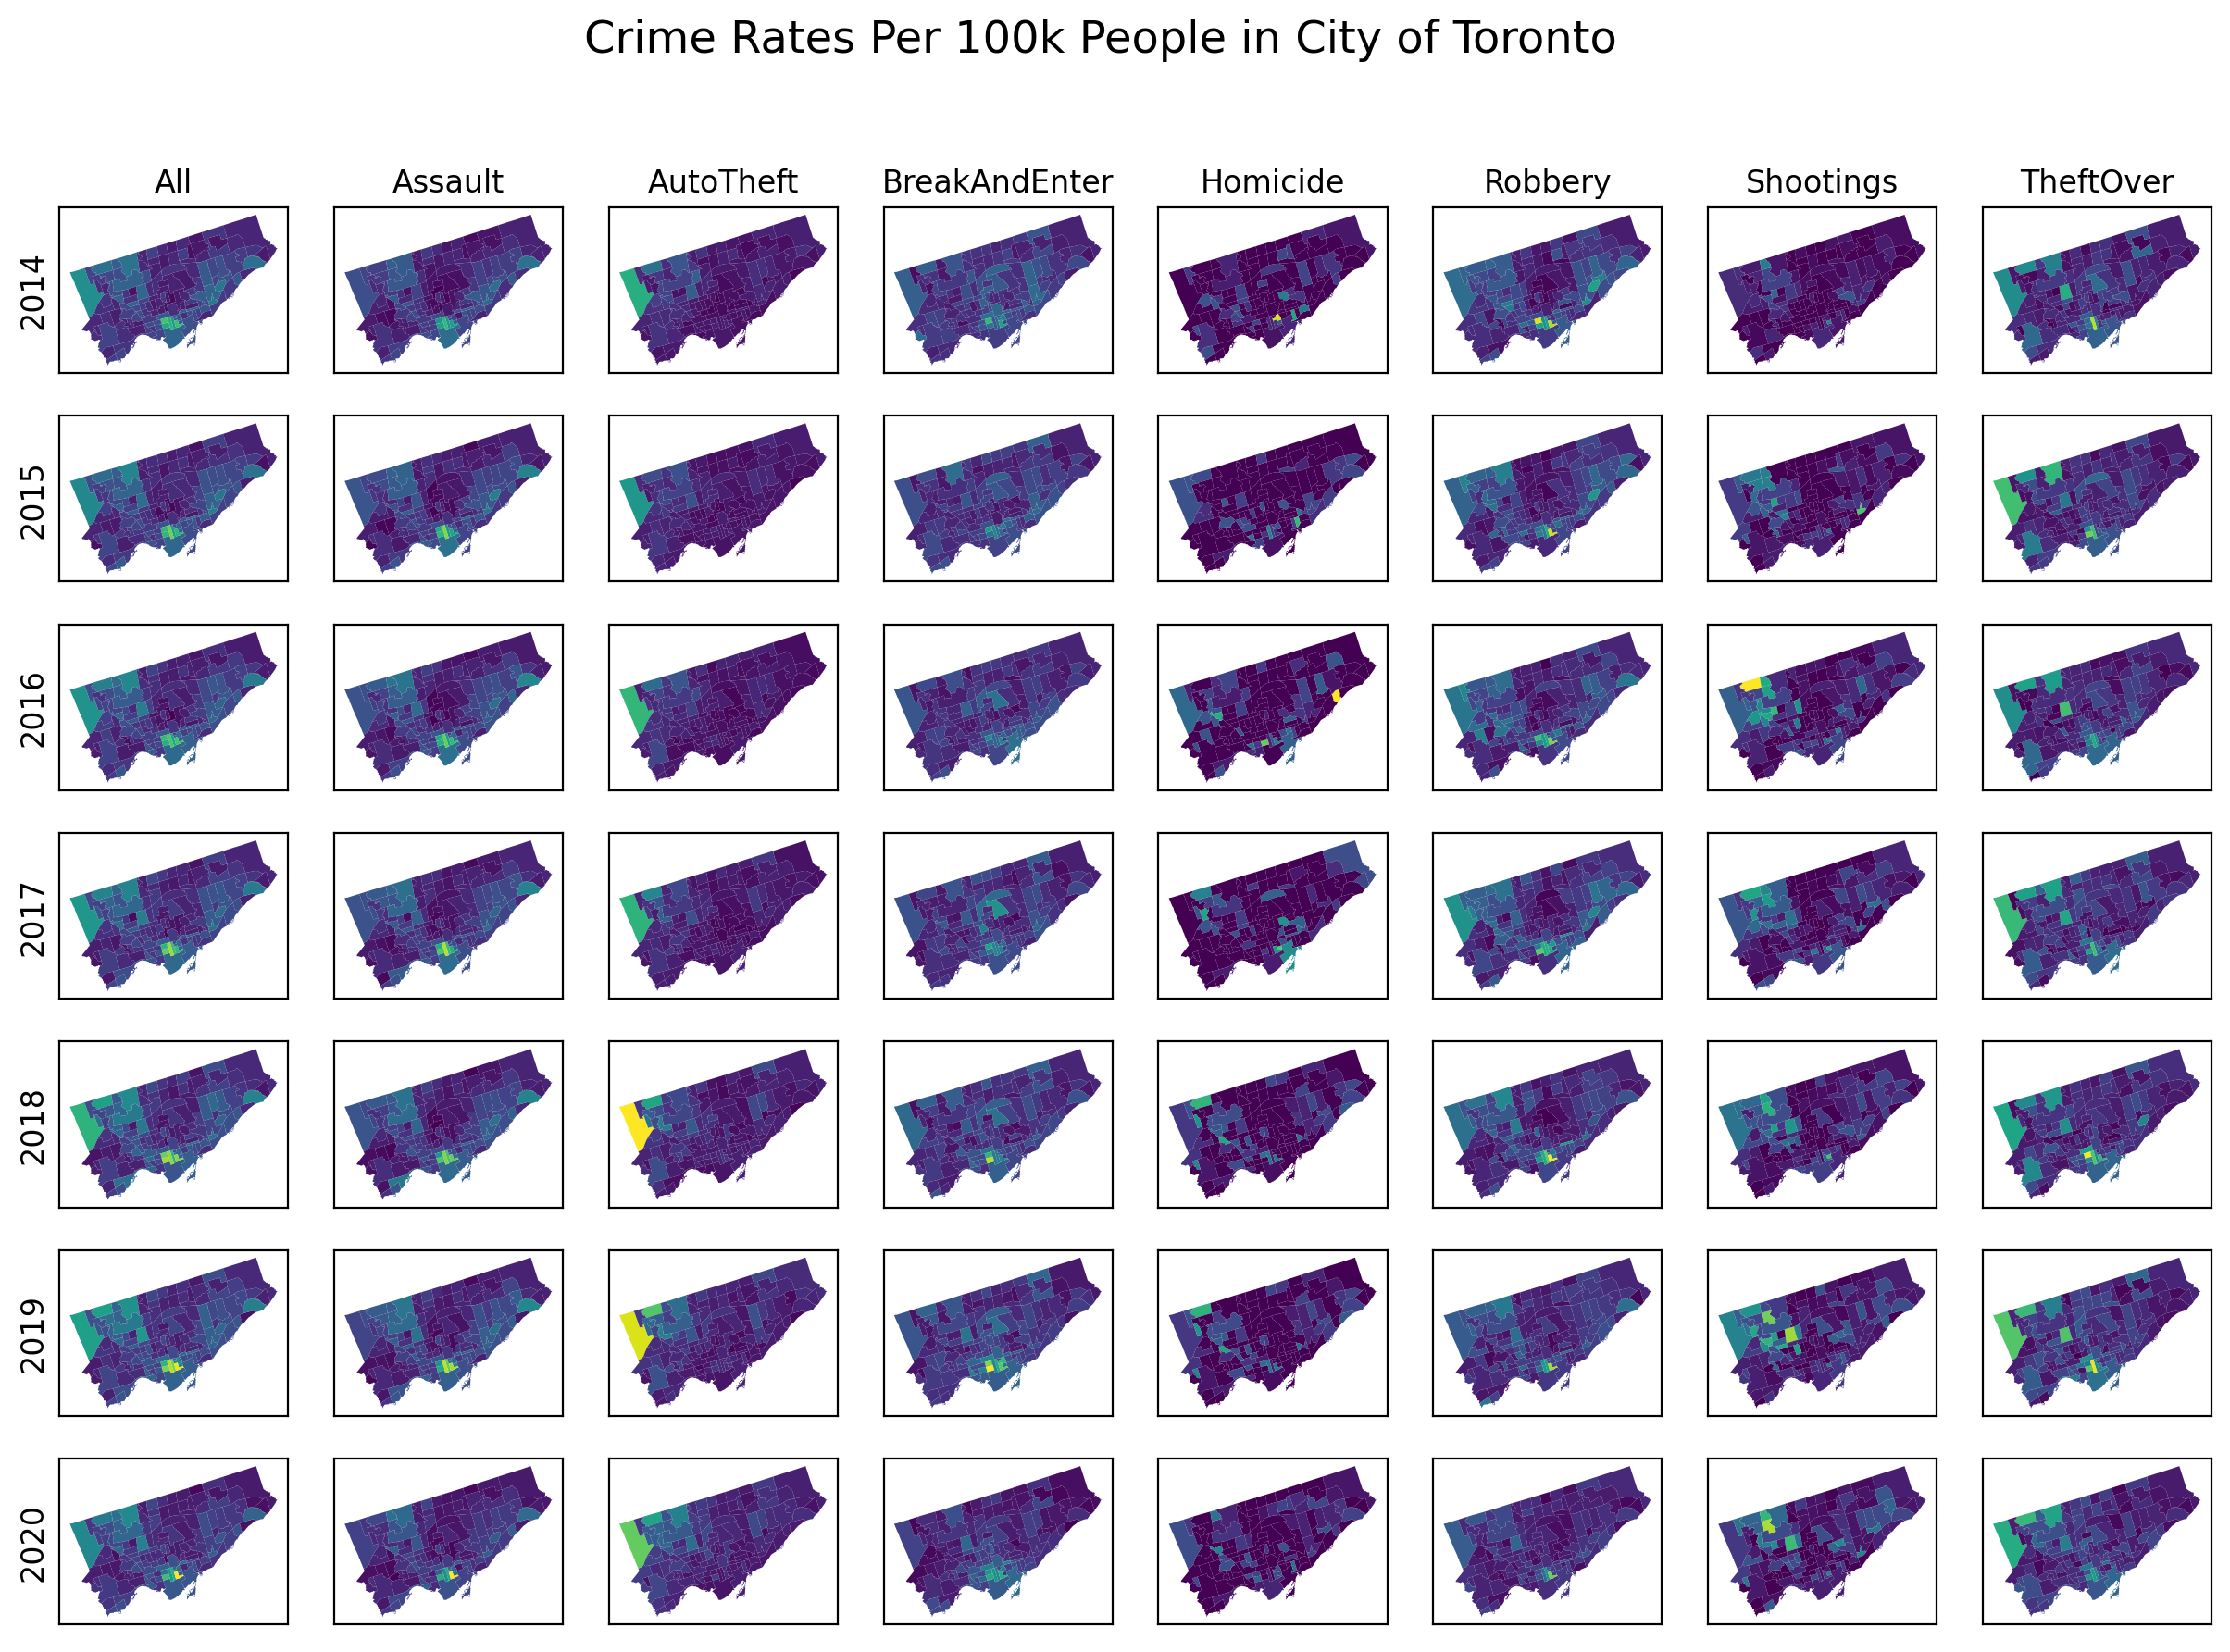

In [23]:
plot_crime(crime_rates, 'Crime Rates Per 100k People in City of Toronto')

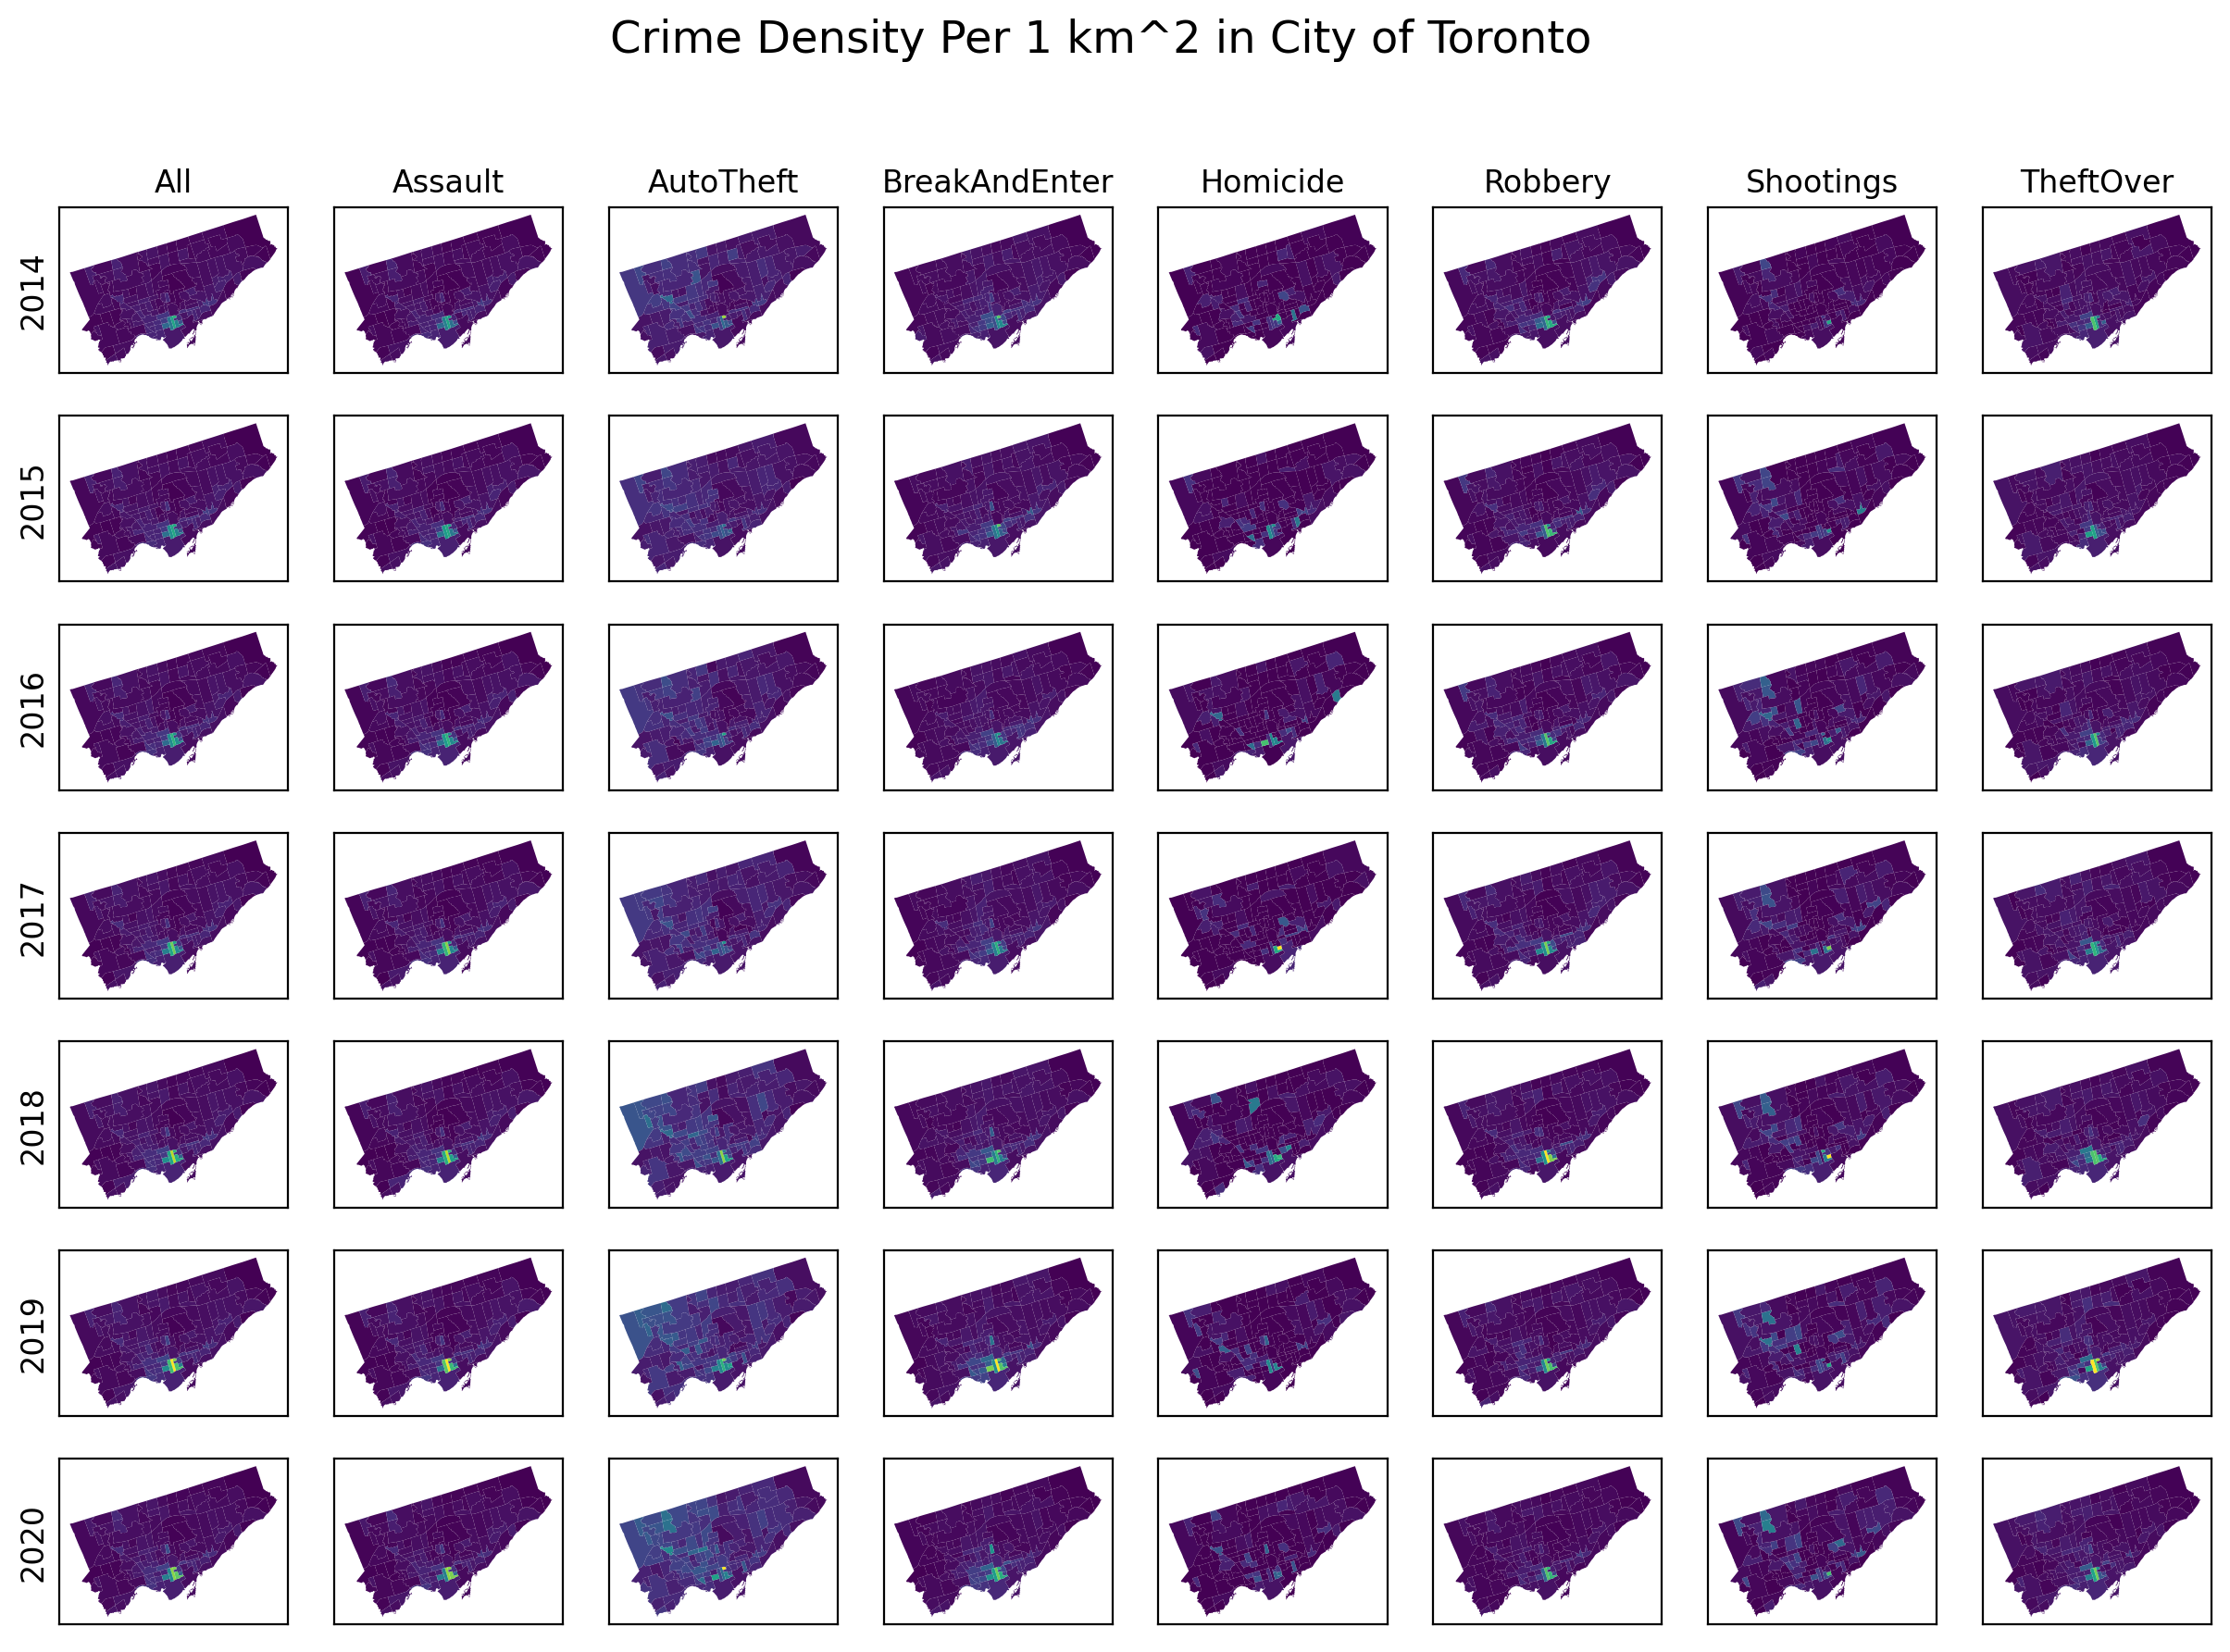

In [24]:
plot_crime(crime_density, 'Crime Density Per 1 km^2 in City of Toronto')

In [25]:
# plotly version
# crime_allrate = pd.wide_to_long(neighborhoods[['Neighbourhood', 'Hood_ID', 'geometry'] + ['All_Rate' + str(year) for year in years]], 
#                                   stubnames= "All_Rate", 
#                                   i=['Neighbourhood', 'Hood_ID'], 
#                                   j='year',
#                                   sep='').reset_index()

# crime_allrate.head()

# fig = px.choropleth(crime_allrate, 
#               geojson=crime_allrate.geometry,
#               locations=crime_allrate.index,
#               color = 'All_Rate',
#               animation_frame='year',
#               color_continuous_scale="Viridis",
#               hover_data=['Neighbourhood'])
# fig.update_geos(fitbounds="locations", visible=False)

# Import major crime indicators

In [26]:
# geojson format is too big -> use csv instead
mci_point = pd.read_csv('./clean_data/mci_point.csv')
mci_point['geometry'] = mci_point.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)
mci_point = gpd.GeoDataFrame(mci_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

In [27]:
mci_point

X             Y  Index_ event_unique_id Division  \
0      -8.854229e+06  5.425760e+06       1  GO-20141624853      D31   
1      -8.834951e+06  5.412259e+06       2  GO-20141625057      D51   
2      -8.825836e+06  5.417935e+06       3  GO-20141259602      D41   
3      -8.847703e+06  5.416571e+06       4  GO-20141260128      D12   
4      -8.837275e+06  5.411569e+06       5  GO-20141259483      D52   
...              ...           ...     ...             ...      ...   
259618 -8.835231e+06  5.421552e+06  262198   GO-2021995584      D53   
259619 -8.849750e+06  5.417652e+06  262199   GO-2021994271      D12   
259620 -8.849750e+06  5.417652e+06  262200   GO-2021994271      D12   
259621 -8.834998e+06  5.421758e+06  262201   GO-2021994920      D53   
259622 -8.835737e+06  5.421780e+06  262202   GO-2021995141      D53   

                   occurrencedate            reporteddate premisetype  \
0       2014-03-02 05:00:00+00:00  2014/03/02 05:00:00+00   Apartment   
1       2014-03-02 05:00:00+00:00  2014/03/02 05:00:00+00  Commercial   
2       2013-12-31 05:00:00+00:00  2014/01/01 05:00:00+00  Commercial   
3       2014-01-01 05:00:00+00:00  2014/01/01 05:00:00+00       House   
4       2013-12-31 05:00:00+00:00  2014/01/01 05:00:00+00     Transit   
...                           ...                     ...         ...   
259618  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00       House   
259619  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00     Outside   
259620  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00     Outside   
259621  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00       House   
259622  2021-05-29 04:00:00+00:00  2021/05/29 04:00:00+00     Outside   

        ucr_code  ucr_ext  ... occurrencedayofyear  occurrencedayofweek  \
0           1430      100  ...                61.0           Sunday       
1           2120      200  ...                61.0           Sunday       
2           2120      220  ...               365.0           Tuesday      
3           1430      100  ...                 1.0           Wednesday    
4           1430      100  ...               365.0           Tuesday      
...          ...      ...  ...                 ...                  ...   
259618      2135      210  ...               149.0           Saturday     
259619      2135      210  ...               149.0           Saturday     
259620      2135      210  ...               149.0           Saturday     
259621      2135      210  ...               149.0           Saturday     
259622      2135      210  ...               149.0           Saturday     

       occurrencehour              MCI  Hood_ID        Neighbourhood  \
0                   5          Assault       22           Humbermede   
1                   4  Break and Enter       73            Moss Park   
2                  23  Break and Enter      121             Oakridge   
3                   1          Assault      111    Rockcliffe-Smythe   
4                  21          Assault       76  Bay Street Corridor   
...               ...              ...      ...                  ...   
259618              2       Auto Theft       56   Leaside-Bennington   
259619              0       Auto Theft      115         Mount Dennis   
259620              0       Auto Theft      115         Mount Dennis   
259621              2       Auto Theft       56   Leaside-Bennington   
259622              3       Auto Theft       56   Leaside-Bennington   

             Long        Lat ObjectId                    geometry  
0      -79.538894  43.743025        1  POINT (-79.53889 43.74302)  
1      -79.365716  43.655340        2  POINT (-79.36572 43.65534)  
2      -79.283837  43.692217        3  POINT (-79.28384 43.69222)  
3      -79.480268  43.683360        4  POINT (-79.48027 43.68336)  
4      -79.386589  43.650853        5  POINT (-79.38659 43.65085)  
...           ...        ...      ...                         ...  
259618 -79.368232  43.715704   262703  POINT (-

# Import traffic collisions

In [28]:
# geojson format is too big -> use csv instead
collision_point = pd.read_csv('./clean_data/collision_point.csv')
collision_point['geometry'] = collision_point.apply(lambda x: shapely.geometry.Point(x['Long'], x['Lat']), axis=1)
collision_point = gpd.GeoDataFrame(collision_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

In [29]:
collision_point

X             Y  OBJECTID   EventUniqueId  \
0       0.000000e+00  0.000000e+00       278  GO-20141591056   
1       0.000000e+00  0.000000e+00      1246  GO-20143120578   
2       0.000000e+00  0.000000e+00     21564  GO-20168056919   
3       0.000000e+00  0.000000e+00     21709  GO-20168059092   
4       0.000000e+00  0.000000e+00     21277  GO-20168053844   
...              ...           ...       ...             ...   
430281 -8.865398e+06  5.426816e+06    499212  GO-20178006796   
430282 -8.865398e+06  5.426816e+06    499213  GO-20178007507   
430283 -8.865398e+06  5.426816e+06    499214  GO-20178008123   
430284 -8.865398e+06  5.426816e+06    499215  GO-20178014940   
430285 -8.865398e+06  5.426816e+06    499216  GO-20178020054   

                OccurrenceDate     Month Day_of_Week  Year  Hour Division  \
0       2014/02/24 05:00:00+00  February      Monday  2014    17      D32   
1       2014/10/17 04:00:00+00   October      Friday  2014     9      D31   
2       2016/12/17 05:00:00+00  December    Saturday  2016     9      D31   
3       2016/12/27 05:00:00+00  December     Tuesday  2016    18      D32   
4       2016/11/30 05:00:00+00  November   Wednesday  2016    18      D33   
...                        ...       ...         ...   ...   ...      ...   
430281  2017/02/14 05:00:00+00  February     Tuesday  2017    14      NSA   
430282  2017/02/18 05:00:00+00  February    Saturday  2017    13      NSA   
430283  2017/02/22 05:00:00+00  February   Wednesday  2017    22      D23   
430284  2017/04/07 04:00:00+00     April      Friday  2017    14      NSA   
430285  2017/05/07 04:00:00+00       May      Sunday  2017    16      NSA   

        ...             Neighbourhood Fatalities  Injury_Collisions  \
0       ...     St.Andrew-Windfields           0                 NO   
1       ...   Glenfield-Jane Heights           0                 NO   
2       ...  York University Heights           0                 NO   
3       ...       Yorkdale-Glen Park           0                 NO   
4       ...        Hillcrest Village           0                 NO   
...     ...                       ...        ...                ...   
430281  ...                       NSA          0                 NO   
430282  ...                       NSA          0                 NO   
430283  ...   West Humber-Clairville           0                 NO   
430284  ...                       NSA          0                 NO   
430285  ...                       NSA          0                 NO   

       FTR_Collisions PD_Collisions       Long        Lat  ObjectId2  Hood_ID  \
0                 YES            NO -79.402034  43.748097        178       40   
1                  NO           YES -79.513544  43.743014       1046       25   
2                  NO           YES -79.498253  43.763907      21094       27   
3                 YES            NO -79.459962  43.707040      21162       31   
4                  NO           YES -79.352088  43.807805      21340       48   
...               ...           ...        ...        ...        ...      ...   
430281             NO           YES -79.639225  43.749873     499534      NSA   
430282            YES            NO -79.639225  43.749873     499535      NSA   
430283             NO           YES -79.639225  43.749873     499536        1   
430284             NO           YES -79.639225  43.749873     499537      NSA   
430285             NO           YES -79.639225  43.749873     499538      NSA   

                          geometry  
0       POINT (-79.40203 43.74810)  
1       POINT (-79.51354 43.74301)  
2       POINT (-79.49825 43.76391)  
3       POINT (-79.45996 43.70704)  
4       POINT (-79.35209 43.80780)  
...                            ...  
430281  POINT (-79.63923 43.74987)  
430282  POINT (-79.63923 43.74987)  
430283  POINT (-79.63923 43.74987)  
430284  POINT (-79.63923 43.74987)  
430285  POINT (-79.63923 43.74987)  

[430286 rows x 21 columns]

# Crime around subway stations

In [30]:
crime_around_stations = gpd.sjoin(mci_point, stations_area, op='intersects')
crime_around_stations

X             Y  Index_ event_unique_id Division  \
4      -8.837275e+06  5.411569e+06       5  GO-20141259483      D52   
61     -8.836874e+06  5.410915e+06      66  GO-20141262372      D52   
583    -8.836993e+06  5.410881e+06     795  GO-20141328312      D52   
663    -8.837155e+06  5.411264e+06     976  GO-20141343564      D52   
926    -8.836833e+06  5.411571e+06     247  GO-20141274610      D52   
...              ...           ...     ...             ...      ...   
202539 -8.851130e+06  5.431108e+06  205396  GO-20201490510      D31   
211149 -8.851130e+06  5.431108e+06  213747  GO-20202193214      D31   
214977 -8.851130e+06  5.431108e+06  217867   GO-2021101646      D31   
225937 -8.851130e+06  5.431108e+06  228998  GO-20211136719      D31   
230404 -8.853438e+06  5.433740e+06  233332  GO-20143349474      NSA   

                   occurrencedate            reporteddate premisetype  \
4       2013-12-31 05:00:00+00:00  2014/01/01 05:00:00+00     Transit   
61      2014-01-01 05:00:00+00:00  2014/01/01 05:00:00+00  Commercial   
583     2014-01-12 05:00:00+00:00  2014/01/12 05:00:00+00       Other   
663     2014-01-12 05:00:00+00:00  2014/01/14 05:00:00+00   Apartment   
926     2014-01-03 05:00:00+00:00  2014/01/03 05:00:00+00  Commercial   
...                           ...                     ...         ...   
202539  2020-08-09 04:00:00+00:00  2020/08/09 04:00:00+00  Commercial   
211149  2020-11-19 05:00:00+00:00  2020/11/19 05:00:00+00     Outside   
214977  2021-01-17 05:00:00+00:00  2021/01/17 05:00:00+00     Outside   
225937  2021-06-17 04:00:00+00:00  2021/06/17 04:00:00+00     Transit   
230404  2014-11-08 05:00:00+00:00  2014/11/22 05:00:00+00     Outside   

        ucr_code  ucr_ext  ... distance_km_order  commute_time_order  \
4           1430      100  ...                17                   8   
61          2120      200  ...                17                   8   
583         1430      100  ...                17                   8   
663         2130      210  ...                17                   8   
926         2130      210  ...                17                   8   
...          ...      ...  ...               ...                 ...   
202539      1430      100  ...                70                  61   
211149      1430      100  ...                70                  61   
214977      1430      100  ...                70                  61   
225937      1420      110  ...                70                  61   
230404      2135      210  ...                74                  64   

                                                      url  \
4       https://www.ttc.ca/subway-stations/st-andrew-s...   
61      https://www.ttc.ca/subway-stations/st-andrew-s...   
583     https://www.ttc.ca/subway-stations/st-andrew-s...   
663     https://www.ttc.ca/subway-stations/st-andrew-s...   
926     https://www.ttc.ca/subway-stations/st-andrew-s...   
...                                                   ...   
202539  https://www.ttc.ca/subway-stations/pioneer-vil...   
211149  https://www.ttc.ca/subway-stations/pioneer-vil...   
214977  https://www.ttc.ca/subway-stations/pioneer-vil...   
225937  https://www.ttc.ca/subway-stations/pioneer-vil...   
230404  https://www.ttc.ca/subway-stations/vaughan-met...   

                            station                     line order  longitude  \
4                         st andrew  Line 1 Yonge-University    17 -79.384808   
61                        st andrew  Line 1 Yonge-University    17 -79.384808   
583                       st andrew  Line 1 Yonge-University    17 -79.384808   
663                       st andrew  Line 1 Yonge-University    17 -79.384808   
926                       st andrew  Line 1 Yonge-University    17 -79.384808   
...                             ...                      ...   ...        ...   
202539              pioneer village  Line 1 Yonge-University    35 -79.510329   
211149              pioneer village  Line 1

<AxesSubplot:>

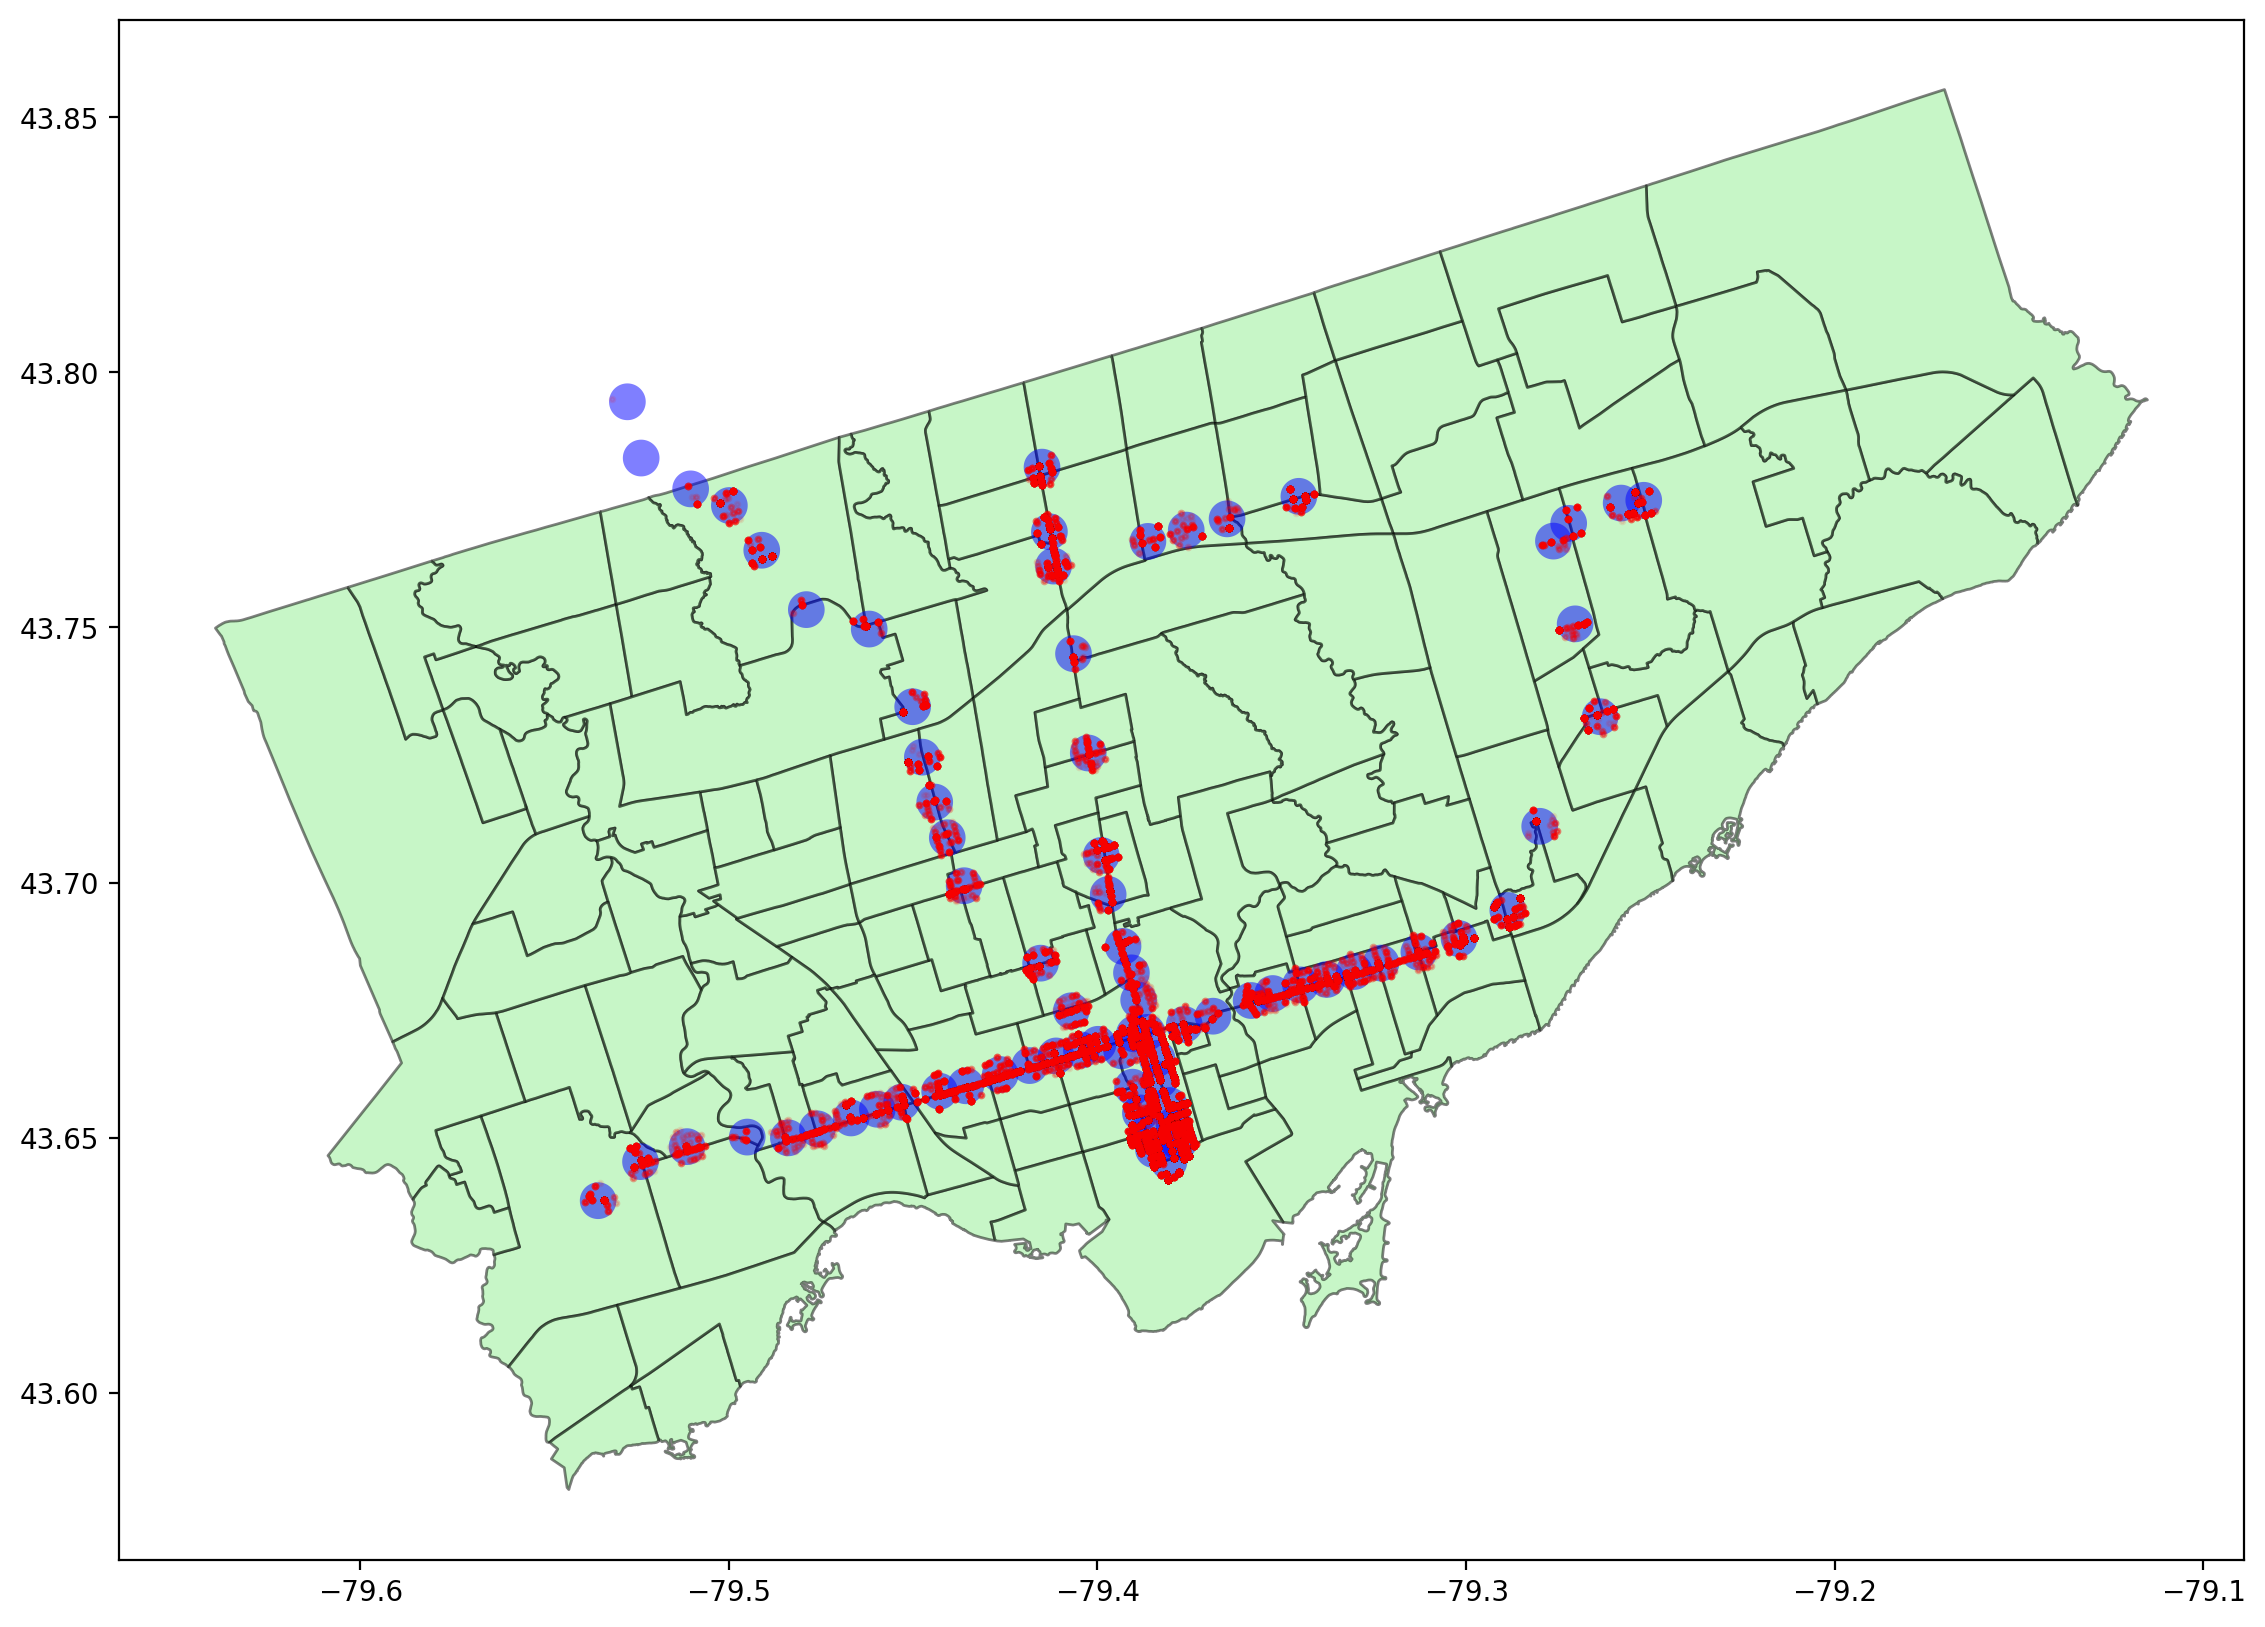

In [31]:
ax = neighborhoods.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
stations_area.plot(ax=ax, color = 'blue', markersize = 3, alpha = 0.5)
crime_around_stations.plot(ax=ax, color = 'red', markersize = 3, alpha = 0.1)

<AxesSubplot:>

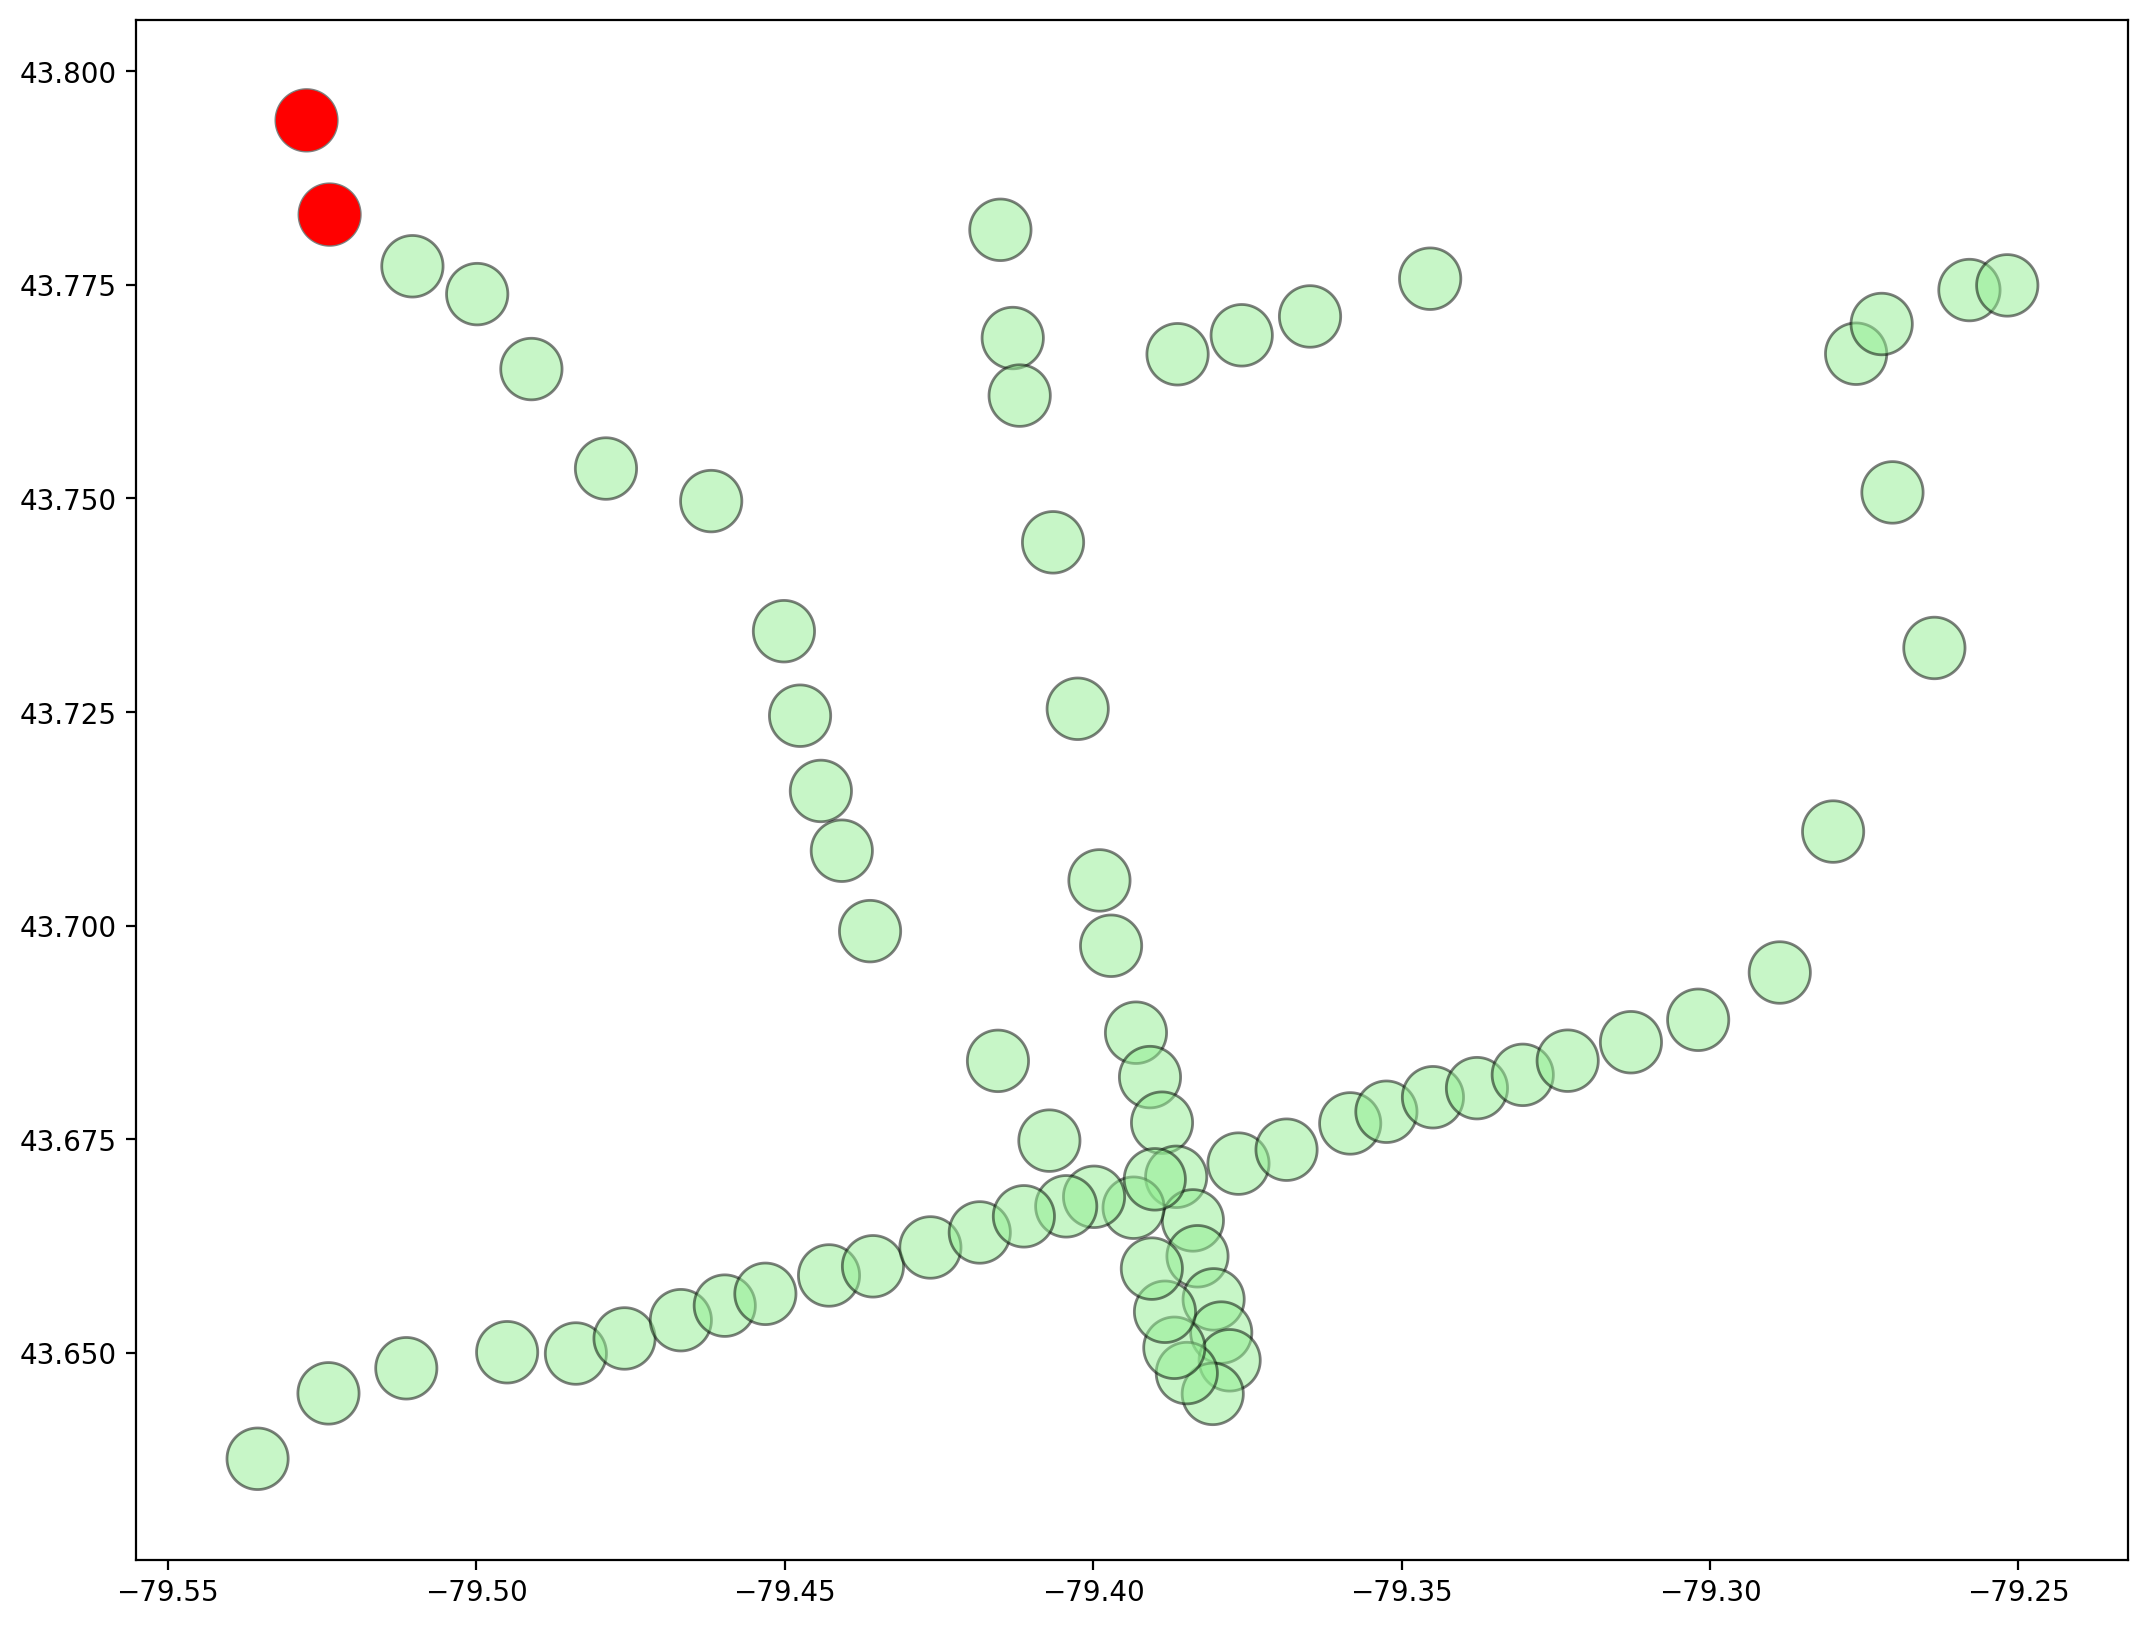

In [32]:
# checking there are actually crime around the 2 stations outside the neighbourhoods
ax = stations_area.plot(color = 'lightgreen', edgecolor = 'black', alpha = 0.5)
stations_area[(stations_area['station'] == 'highway 407') | (stations_area['station'] == 'vaughan metropolitan centre')].plot(ax=ax, color = 'red', markersize = 3)

In [33]:
gpd.sjoin(mci_point, stations_area[(stations_area['station'] == 'highway 407') | (stations_area['station'] == 'vaughan metropolitan centre')],
          op='intersects')

X             Y  Index_ event_unique_id Division  \
230404 -8.853438e+06  5.433740e+06  233332  GO-20143349474      NSA   

                   occurrencedate            reporteddate premisetype  \
230404  2014-11-08 05:00:00+00:00  2014/11/22 05:00:00+00     Outside   

        ucr_code  ucr_ext  ... distance_km_order  commute_time_order  \
230404      2135      210  ...                74                  64   

                                                      url  \
230404  https://www.ttc.ca/subway-stations/vaughan-met...   

                            station                     line order  longitude  \
230404  vaughan metropolitan centre  Line 1 Yonge-University    37 -79.527487   

         latitude commute_time  distance_km  
230404  43.794244           44    18.050994  

[1 rows x 42 columns]

In [34]:
crime_around_stations.groupby('station')['event_unique_id'].count().sort_values(ascending=False)

station
dundas                         4856
college                        3633
queen                          3583
wellesley                      2983
bloor yonge                    2461
                               ... 
ellesmere                        83
old mill                         56
pioneer village                  53
downsview park                   42
vaughan metropolitan centre       1
Name: event_unique_id, Length: 74, dtype: int64

# Neighborhood crime rate

In [35]:
neighbourhood_count = pd.DataFrame(mci_point["Hood_ID"].value_counts())
neighbourhood_count = neighbourhood_count.reset_index().rename(columns = {'index': 'Hood_ID', 'Hood_ID': 'count'})
neighbourhood_count

Hood_ID  count
0        77   9645
1        75   8563
2        76   7619
3         1   6939
4        73   6382
..      ...    ...
136     140    496
137      97    486
138      60    473
139      29    472
140     114    405

[141 rows x 2 columns]